# Oakland University Baseball Analytics - 2024

Author : Aswini Sivakumar

### Loading the libraries

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import xml.etree.ElementTree as ET

Loading the libraries required for modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import graphviz

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Parse the XML file and get the root of the XML tree

In [ ]:
# Define the directory where the XML files are located
directory = '/content/drive/MyDrive/OU Baseball Stats/XML_Files_2024/'

# Initialize a list to store the root of each XML tree
roots = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    # Check if the file is an XML file
    if filename.endswith('.XML'):
        # Parse the XML file and get the root of the XML tree
        tree = ET.parse(os.path.join(directory, filename))
        root = tree.getroot()

        # Add the root to the list
        roots.append(root)

Identify the respective tag for the Oakland University team and extract the overall player stats and play-by-play stats for the games played

In [ ]:
# Find Tags where team id is "OAK"
oak_team = []
for root in roots:
    oak_team.extend(root.findall('.//team[@id="OAK"]'))

# Get all the players in "OAK" team
players = []
for team in oak_team:
    players.extend(team.findall('.//player'))

# Get the innings wise batting stats
batting = []
for root in roots:
    batting.extend(root.findall('.//batting[@id="OAK"]'))

# Get play-by-play stats for each innings
play_data = []
for plays in batting:
    play_data.extend(plays.findall('.//play'))


Extracting necessary features from the play-by-play data

In [ ]:
pitch_df = []

for play in play_data:
    batter = play.find('batter')
    if batter is not None:

      # variables extracted from player tag
      player_name = play.attrib['batter']
      batprof = play.attrib['batprof']          # Categorical - if the batter is Left handed or Right handed
      pchprof = play.attrib['pchprof']          # Categorical - if the pitcher is Left handed or Right handed
      outs = play.attrib['outs']                # Numerical - number of outs already occured in the half innings when the play happened
      first = play.attrib.get('first',None)     # Player at the first base
      second = play.attrib.get('second',None)   # Player at the second base
      third = play.attrib.get('third',None)     # Player at the third base

      # creating categorical variables to identify if the bases are loaded
      first_occ = 1 if first is not None else 0
      sec_occ = 1 if second is not None else 0
      third_occ = 1 if third is not None else 0

      # variables extracted from batter tag
      tobase = batter.attrib.get('tobase', 0)
      play_result = batter.attrib.get('action', None)
      onbase = 1 if tobase != 'N/A' and int(tobase) > 0 else 0
      ab = batter.attrib.get('ab',0)
      h = batter.attrib.get('h',0)
      rbi = batter.attrib.get('rbi',0)
      double = batter.attrib.get('double', 0)
      triple = batter.attrib.get('triple', 0)

      # converting rbi to have 2 categories - 0 and 1, so rbi of 1,2,3 and 4 will be treated as 1
      c_rbi = 1 if int(rbi) > 0 else 0

      pitches = play.find('pitches')
      if pitches is not None:
          PitchSeq = pitches.attrib.get('text', None)
          balls = pitches.attrib.get('b', 0)
          strikes = pitches.attrib.get('s', 0)

      pitch_df.append([player_name, batprof, pchprof, outs, PitchSeq, tobase, play_result, onbase, ab, h, rbi, c_rbi, double, triple, first_occ, sec_occ, third_occ, balls, strikes])

Creating a dataframe using the extracted variables

In [ ]:
pitch_df_1 = pd.DataFrame(pitch_df, columns=['player_name', 'BatterSide', 'Context', 'outs', 'PitchSeq', 'tobase', 'PlayResult', 'onbase(y/n)', 'ab', 'h', 'rbi', 'c_rbi', 'double', 'triple','first_occ', 'sec_occ', 'third_occ' ,'balls','strikes'])
pitch_df_1.head()

,player_name,BatterSide,Context,outs,PitchSeq,tobase,PlayResult,onbase(y/n),ab,h,rbi,c_rbi,double,triple,first_occ,sec_occ,third_occ,balls,strikes
0,R. Bussey,L,R,0,KSBBBK,0,KL,0,1,0,0,0,0,0,0,0,0,3,3
1,B. Heidal,R,R,1,SBBSP,1,1B 6,1,1,1,0,0,0,0,0,0,0,2,2
2,I. Cleary,L,R,1,FP,0,F7,0,1,0,0,0,0,0,1,0,0,0,1
3,B. Nigh,R,R,2,BSKS,0,KS,0,1,0,0,0,0,0,1,0,0,1,3
4,L. Day,L,R,0,P,0,P4,0,1,0,0,0,0,0,0,0,0,0,0


# EDA for RBI

Distribution of RBI

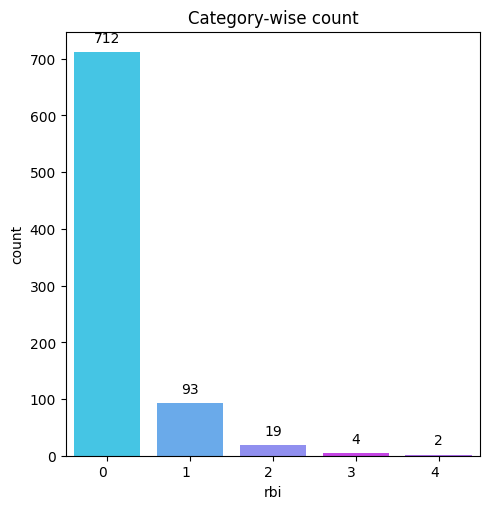

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x="rbi", hue="rbi", data=pitch_df_1, order=pitch_df_1['rbi'].value_counts().index, palette="cool", legend=False)

# Add value counts to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(),  ha="right")
plt.tight_layout()
plt.title("Category-wise count")
plt.show()

# Model to predict *RBI*

Converting the categorical variables to numerical format

In [ ]:
pitch_df_1['player_name_orig']=pitch_df_1['player_name']

# Initialize LabelEncoder
encoder = LabelEncoder()

# Encode categorical columns
for col in ['player_name', 'BatterSide', 'Context']:   # L = 1 R = 0
    pitch_df_1[col] = encoder.fit_transform(pitch_df_1[col])

Seperating the multi-class categorical variable from the other features

In [ ]:
# Seperating the multi-class categorical variable from the other features
other_features = pitch_df_1[['BatterSide', 'Context', 'outs', 'ab', 'double', 'triple', 'first_occ', 'sec_occ', 'third_occ', 'balls', 'strikes']]

# Create dummy variables for the multi-class categorical variable 'player name'
pitch_df_1_encoded = pd.get_dummies(pitch_df_1['player_name'])

# Concatenate one-hot encoded DataFrame with the 'player_name' column
X_encoded = pd.concat([pitch_df_1_encoded, other_features], axis=1)

X_encoded = X_encoded.drop(columns=[0]) # 0 is the reference

y1 = pitch_df_1['c_rbi']
y1 = pd.to_numeric(y1)

X_encoded.columns = X_encoded.columns.astype(str)

The data is split into 80% training data and 20 % test data

In [ ]:
# Splitting the data into training and testing sets again with the new variables
X1_train, X1_test, y1_train, y1_test = train_test_split(X_encoded, y1, test_size=0.2, random_state=42)
print('Data preprocessing complete. Training set size:', X1_train.shape[0], 'Testing set size:', X1_test.shape[0])

Data preprocessing complete. Training set size: 664 Testing set size: 166


Looking at the mapping of encoded player name to the original player name

In [ ]:
player_mapping = pitch_df_1[['player_name', 'player_name_orig']].drop_duplicates(keep='first')
player_mapping

,player_name,player_name_orig
0,15,R. Bussey
1,2,B. Heidal
2,9,I. Cleary
3,3,B. Nigh
4,12,L. Day
5,7,G. Arseneau
6,0,A. Orr
7,6,E. Larsen
8,16,S. Griffith
27,17,T. Rice


In [ ]:
X1_train.head()

,1,2,3,4,5,6,7,8,9,10,...,Context,outs,ab,double,triple,first_occ,sec_occ,third_occ,balls,strikes
530,False,False,False,False,False,False,False,False,False,False,...,1,0,1,0,0,0,0,0,1,0
675,False,False,False,False,False,False,False,True,False,False,...,1,0,1,0,0,0,0,1,2,1
346,False,False,False,False,False,True,False,False,False,False,...,1,2,1,0,0,0,0,1,3,3
697,False,False,False,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0
599,False,True,False,False,False,False,False,False,False,False,...,1,1,1,0,0,0,1,0,1,3


The classes of 'rbi' are imbalanced. Checking if the proportion of classes are equally split between the train and the test set

In [ ]:
# Total number of observations in y1_train and y1_test
total_train = len(y1_train)
total_test = len(y1_test)

frequency_train = y1_train.value_counts()
frequency_test = y1_test.value_counts()

# Calculate frequency percentages for y1_train
frequency_percentage_train = (frequency_train / total_train) * 100
print("Frequency percentages for y1_train:")
print(frequency_percentage_train)

# Calculate frequency percentages for y1_test
frequency_percentage_test = (frequency_test / total_test) * 100
print("\nFrequency percentages for y1_test:")
print(frequency_percentage_test)

Frequency percentages for y1_train:
c_rbi
0    85.843373
1    14.156627
Name: count, dtype: float64

Frequency percentages for y1_test:
c_rbi
0    85.542169
1    14.457831
Name: count, dtype: float64


The proportion of classes are split similarly among the train and the test data

## Model 1 : Logistic Regression

Fitting the logistic regression model

In [ ]:
# Logistic Regression Model
lr_1 = LogisticRegression(max_iter=1000, random_state=42)
lr_1.fit(X1_train, y1_train)

train_accuracy_lr = accuracy_score(y1_train, lr_1.predict(X1_train))

y_pred_lr = lr_1.predict(X1_test)
test_accuracy_lr = accuracy_score(y1_test, y_pred_lr)

print(f'Model accuracy on the training set: {train_accuracy_lr:.2f}')
print(f'Model accuracy on the testing set: {test_accuracy_lr:.2f}')

Model accuracy on the training set: 0.89
Model accuracy on the testing set: 0.85


The model performed well in both the training and test data with an accuracy of 89% and 85% respectively.

Evaluating the model using Confusion matrix

	 Logistic Regression Confusion Matrix


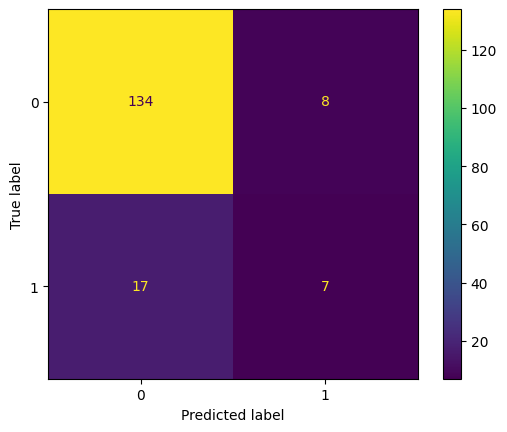

In [ ]:
# Confusion Matrix
lr_cm = confusion_matrix(y1_test, y_pred_lr)
print("\t Logistic Regression Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=lr_cm).plot();

The model predicted 7 out of 24 outcomes of RBI =1 correctly. Even though the accuracy is good, this model could be improved further by adding more significant variables.

Model evaluation using Classification report



1.   Precision is the metric that indicates how often the classifier predicted a class correctly when that class is predicted
2.   Recall is the metric that tells how often a class is predicted correctly when it actually belonged to the class
3.   F1 score is the combination of precision and recall metrics. If the value of either one of the metrics is low, then we can expect a lower F1 score.



In [ ]:
print("\n Classification report for Logistic Regression %s:\n%s\n" % (lr_1, metrics.classification_report(y1_test, y_pred_lr)))


 Classification report for Logistic Regression LogisticRegression(max_iter=1000, random_state=42):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       142
           1       0.47      0.29      0.36        24

    accuracy                           0.85       166
   macro avg       0.68      0.62      0.64       166
weighted avg       0.83      0.85      0.83       166




The precision of class 1 is 0.47. This value represents the number of correctly
identified "1s" divided by the total number of times the classifier predicted "1," whether correctly or incorrectly. Therefore, this indicates that the classifier correctly identified "1s" 47% of the time it predicted a "1".

The sensitivity as indicated by recall of class 0 is 94% and the specificity as indicated by recall of class 1 is 29% which is quite low.


Interprting the results

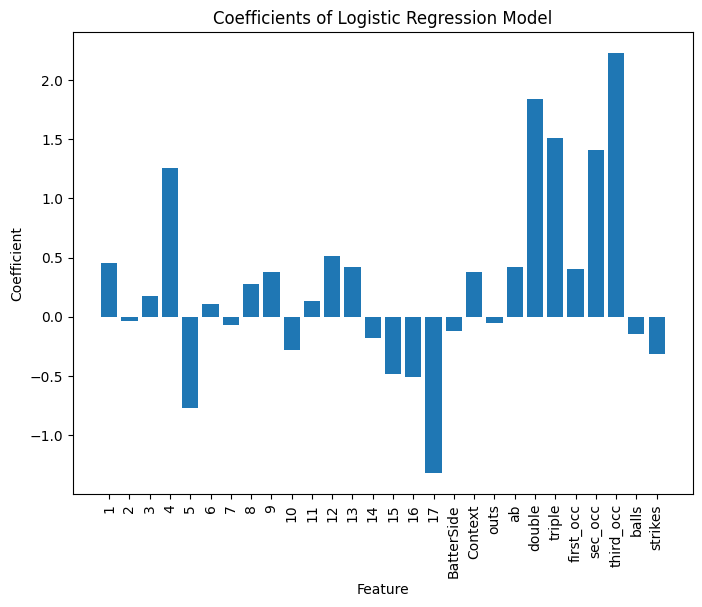

In [ ]:
# Get the coefficients of the logistic regression model
coefficients = lr_1.coef_[0]

# Get the names of the features
feature_names = X_encoded.columns

# Create a bar plot to visualize the coefficients
plt.figure(figsize=(8, 6))
plt.bar(feature_names, coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Coefficients of Logistic Regression Model')
plt.xticks(rotation=90)
plt.show()

In [ ]:
numeric_cols = ['BatterSide', 'Context', 'outs', 'ab', 'double', 'triple', 'first_occ', 'sec_occ', 'third_occ', 'balls', 'strikes']
cat_cols = list(set(X_encoded.columns) - set(numeric_cols))

# Convert elements of cat_cols to integers
cat_cols_int = [int(col) for col in cat_cols]

# Sort the integers
cat_cols_int.sort()

# Convert back to strings
cat_cols_sorted = [str(col) for col in cat_cols_int]

# Display the sorted cat_cols
print(cat_cols_sorted)

print(numeric_cols)


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']
['BatterSide', 'Context', 'outs', 'ab', 'double', 'triple', 'first_occ', 'sec_occ', 'third_occ', 'balls', 'strikes']


Computing Odds ratio

In [ ]:
coefficients = np.hstack((lr_1.intercept_, lr_1.coef_[0]))

# Calculate odds ratio
odds_ratio = np.exp(coefficients)

pd.DataFrame(data={'variable': ['intercept'] + cat_cols_sorted + numeric_cols,
                   'coefficient': coefficients,
                    'odds_ratio': odds_ratio})

,variable,coefficient,odds_ratio
0,intercept,-3.281825,0.037560
1,1,0.450749,1.569487
2,2,-0.031007,0.969469
3,3,0.172779,1.188604
4,4,1.255700,3.510295
5,5,-0.769952,0.463035
6,6,0.110043,1.116326
7,7,-0.069926,0.932463
8,8,0.276857,1.318978
9,9,0.377100,1.458050


Here are the interpretations of few variables from the model-
The odds of a batter scoring an RBI when third base is occupied are 9.25 times higher compared to when third base is unoccupied. This aligns with the expectation that having a runner on third base creates more opportunities for RBIs, as even a simple sacrifice fly or ground ball can drive in the run.

The odds of a left handed batter scoring an RBI are 11.5% times lower than the odds for a right handed batter.

The odds of a batter scoring an RBI are 49% higher when the first base is occupied compared to when the first base is empty.


Here we are including the categorical variable itself in the model and not the dummy variables as the random forest classifier and the decision tree classifier can handle categorical variables.

In [ ]:
X2 = pitch_df_1[['player_name', 'BatterSide', 'Context', 'outs',  'ab', 'double', 'triple', 'first_occ', 'sec_occ', 'third_occ', 'balls', 'strikes']]
y2 = pitch_df_1['c_rbi']
y2 = pd.to_numeric(y1)

# Splitting the data into training and testing sets again with the new variables
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

print('Data preprocessing complete. Training set size:', X2_train.shape[0], 'Testing set size:', X2_test.shape[0])

Data preprocessing complete. Training set size: 664 Testing set size: 166


## Model 2 : Random Forest

Fitting a random forest classifier

In [ ]:
# Model Selection: Random Forest Classifier
rf_1 = RandomForestClassifier(random_state=42)

# Model Training
rf_1.fit(X2_train, y2_train)

train_accuracy_rf = accuracy_score(y2_train, rf_1.predict(X2_train))

# Model Evaluation on the testing set
y1_pred = rf_1.predict(X2_test)
test_accuracy_rf = accuracy_score(y2_test, y1_pred)

print(f'Model accuracy on the training set: {train_accuracy_rf:.2f}')
print(f'Model accuracy on the testing set: {test_accuracy_rf:.2f}')

Model accuracy on the training set: 0.99
Model accuracy on the testing set: 0.86


The model performed well in both the training and test data with an accuracy of 99% and 86% respectively.

Evaluating the random forest classifier using Confusion matrix

	 Random Forest Confusion Matrix


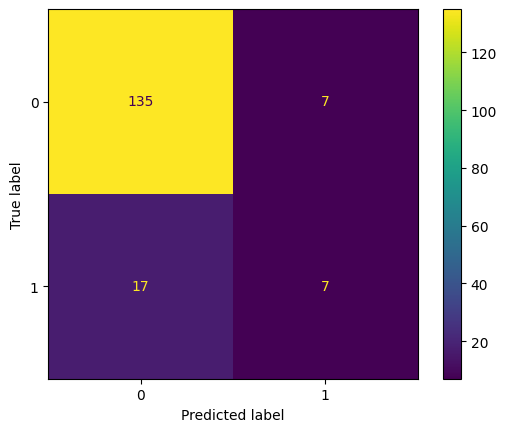

In [ ]:
# Confusion Matrix
rf_cm = confusion_matrix(y2_test, y1_pred)

print("\t Random Forest Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=rf_cm).plot();

The model predicted 7 out of 24 outcomes of RBI =1 correctly which is same as the logistic regression.

Model evaluation using Classification report

In [ ]:
print("\n Classification report for Random Forest classifier %s:\n%s\n" % (rf_1, metrics.classification_report(y2_test, y1_pred)))


 Classification report for Random Forest classifier RandomForestClassifier(random_state=42):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       142
           1       0.50      0.29      0.37        24

    accuracy                           0.86       166
   macro avg       0.69      0.62      0.64       166
weighted avg       0.83      0.86      0.84       166




The precision of class 1 is 0.50. This value represents the number of correctly identified "1s" divided by the total number of times the classifier predicted "1," whether correctly or incorrectly. Therefore, this indicates that the classifier correctly identified "1s" 50% of the time it predicted a "1".

The sensitivity as indicated by recall of class 0 is 95% and the specificity as indicated by recall of class 1 is 29% which is quite low.

Identifying the variable importance of the features

In [ ]:
pd.DataFrame(rf_1.feature_importances_, index=X2.columns).sort_values(by=0, ascending=False)

,0
player_name,0.183655
third_occ,0.178407
strikes,0.120014
outs,0.105272
balls,0.094921
sec_occ,0.091138
double,0.055565
first_occ,0.051104
Context,0.037060
BatterSide,0.036648


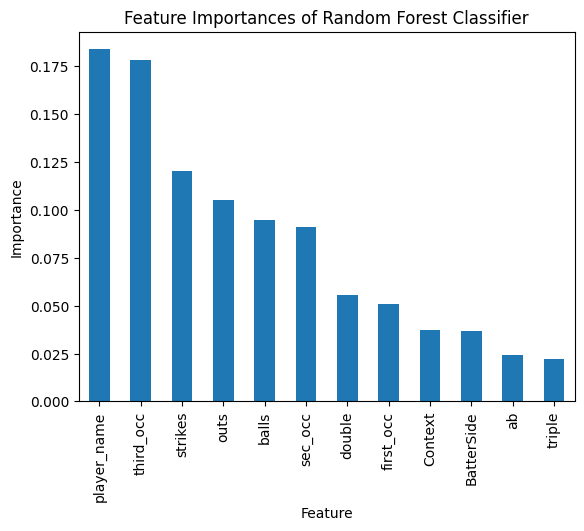

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_1.feature_importances_, index=X2.columns).sort_values(ascending=False)

# Plot a simple bar chart
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances of Random Forest Classifier')
feature_importances.plot.bar();


This tells us that the Player_name and third_occ variables are the most important features in predicting RBI

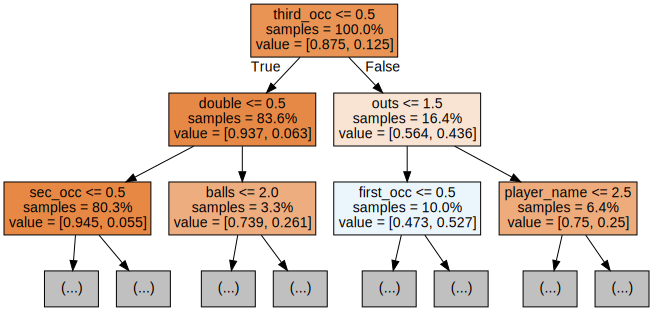

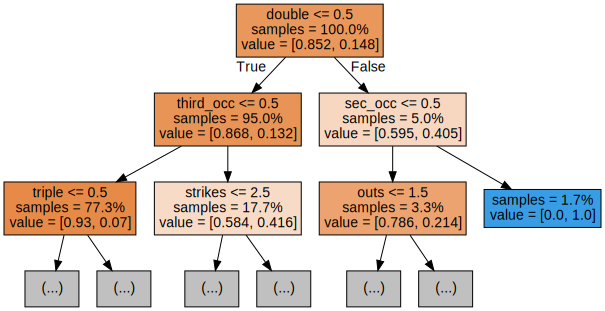

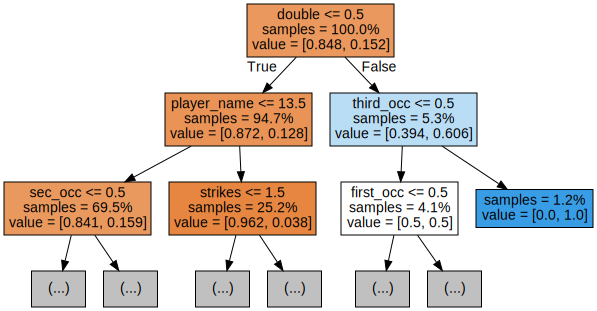

In [ ]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf_1.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X2.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
    graph.render(filename=f"decision_trees/tree_{i}", format="png")

## Model 3 : Decision Tree

Fitting a decision tree classifier

In [ ]:
# Decision Tree Model
tree_1 = DecisionTreeClassifier(random_state=42)
tree_1.fit(X2_train, y2_train)

train_accuracy_tree = accuracy_score(y2_train, tree_1.predict(X2_train))

y_pred_tree_1 = tree_1.predict(X2_test)
accuracy_tree_1 = accuracy_score(y2_test, y_pred_tree_1)

print(f'Model accuracy on the training set: {train_accuracy_tree:.2f}')
print(f'Model accuracy on the testing set: {accuracy_tree_1:.2f}')

Model accuracy on the training set: 0.99
Model accuracy on the testing set: 0.84


The model performed well in both the training and test data with an accuracy of 99% and 84% respectively.

	 Decision Tree Confusion Matrix


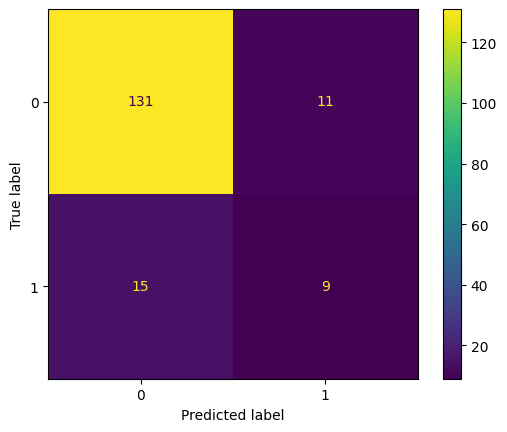

In [ ]:
# Confusion Matrix
tree_1_cm = confusion_matrix(y2_test, y_pred_tree_1)
print("\t Decision Tree Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=tree_1_cm).plot();

The model predicted 9 out of 24 outcomes of RBI =1 correctly which is quite better than the logistic regression and random forest classifier. This model can further be improved by pruning using the gini or entropy criterion.

In [ ]:
print("\n Classification report for Decision Tree %s:\n%s\n" % (tree_1_cm, metrics.classification_report(y2_test, y_pred_tree_1)))


 Classification report for Decision Tree [[131  11]
 [ 15   9]]:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       142
           1       0.45      0.38      0.41        24

    accuracy                           0.84       166
   macro avg       0.67      0.65      0.66       166
weighted avg       0.83      0.84      0.84       166




The precision of class 1 is 0.45. This value represents the number of correctly identified "1s" divided by the total number of times the classifier predicted "1," whether correctly or incorrectly. Therefore, this indicates that the classifier correctly identified "1s" 45% of the time it predicted a "1".

The sensitivity as indicated by recall of class 0 is 92% and the specificity as indicated by recall of class 1 is 38% which is quite low. The specificity is quite improved compared to the other 2 models.

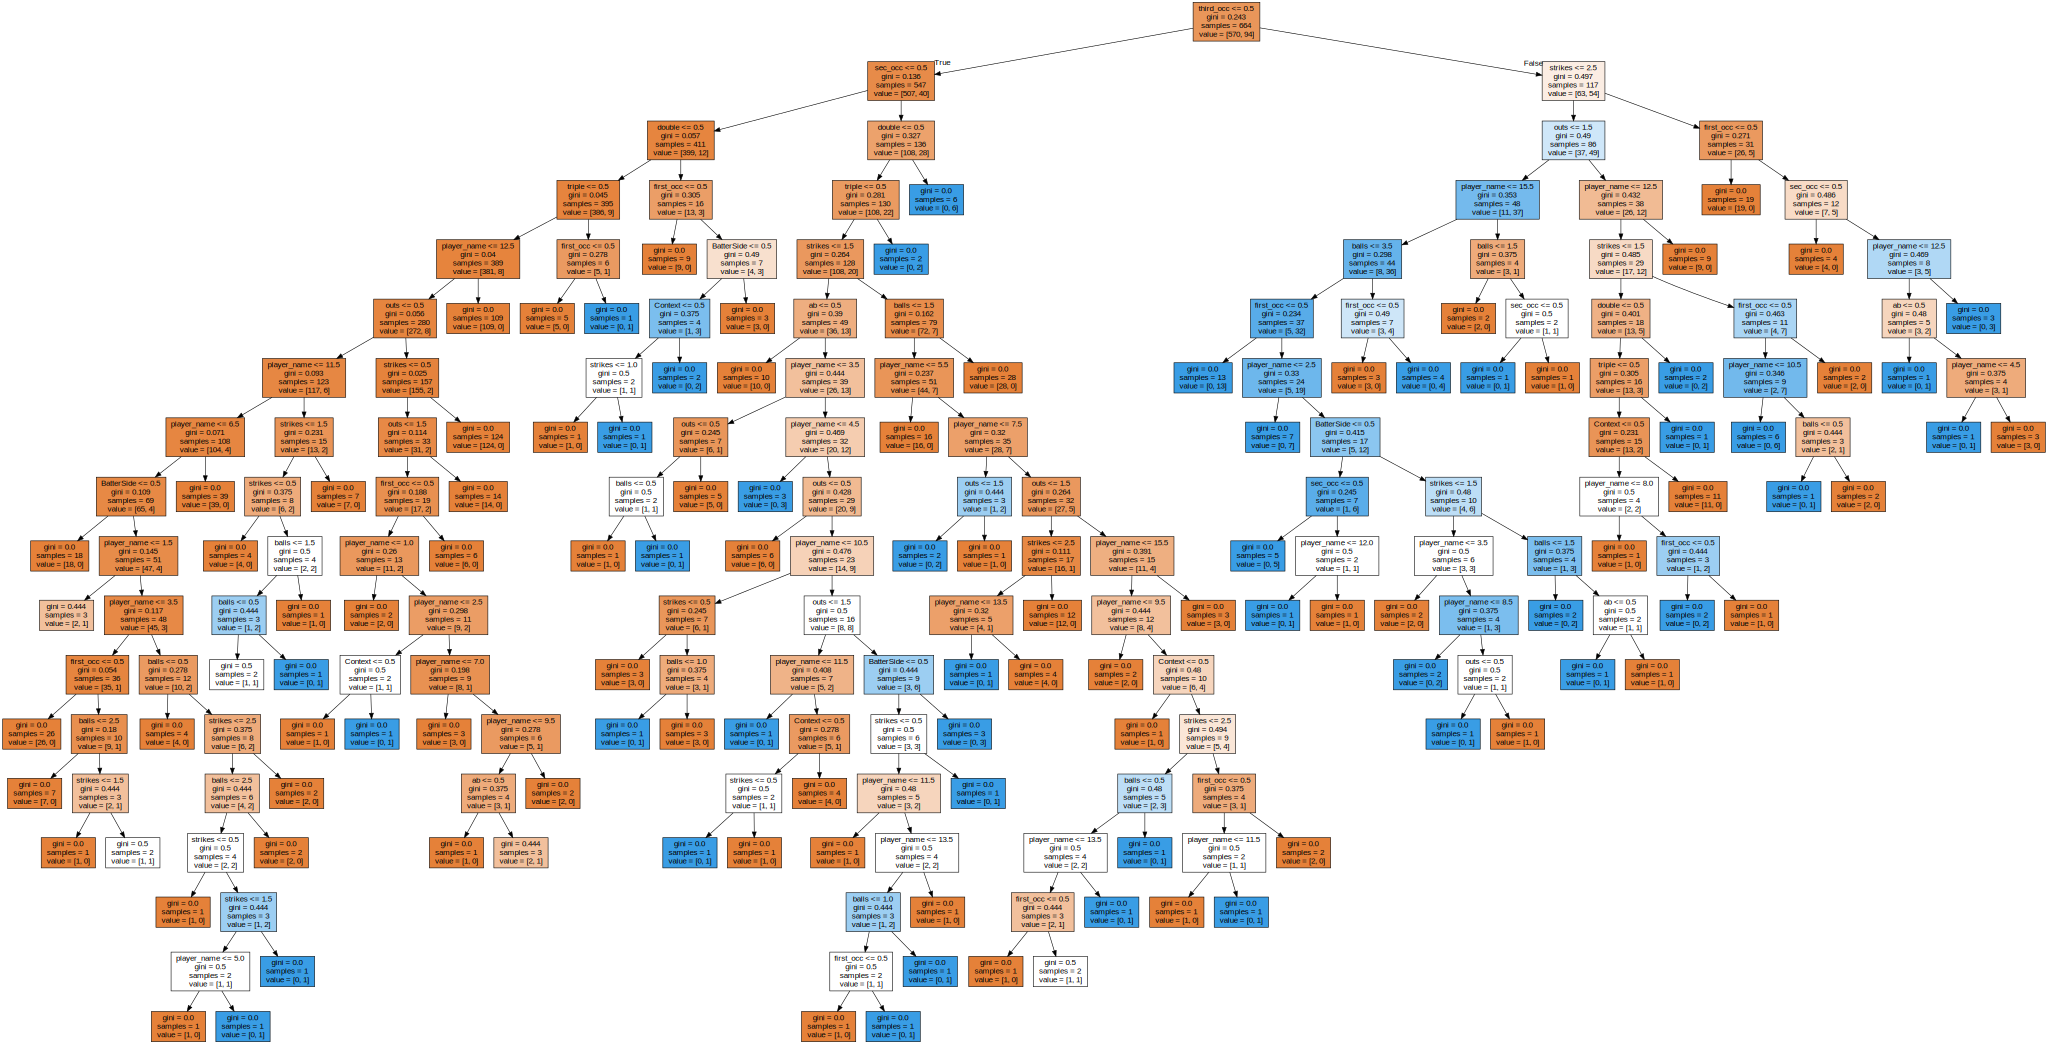

In [ ]:
dot_data = export_graphviz(tree_1, out_file=None, feature_names=X2_train.columns, filled=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saving the tree to a file
display(graph)